In [66]:
# Configuration et imports
import torch
import torch.nn as nn
import numpy as np
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoConfig, AutoModelForImageClassification, AutoImageProcessor
from tabulate import tabulate
# Configuration globale
class Config:
    """Configuration centrale pour l'analyse"""
    GAMMA_DEFAULT = 2.0
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Couleurs par type de modèle
    MODEL_COLORS = {
        'bert': '#1f77b4',      # bleu
        'gpt2': '#ff7f0e',      # orange
        'gpt-neo': '#ff7f0e',   
        'llama': '#ff7f0e',     
        'mistral': '#ff7f0e',
        'vit': '#2ca02c',   
        'custom': '#9467bd'     
    }

config = Config()

In [67]:
print(f"Device : {Config.DEVICE}")

if torch.cuda.is_available():
    print(f"GPU : {torch.cuda.get_device_name(0)}")
else:
    print("CPU seulement")

Device : cuda
GPU : NVIDIA GeForce RTX 4060 Laptop GPU


In [68]:
# Extraction des poids et configurations
def extract_model_info(model, model_type: str) -> Tuple[List, int, int, int]:
    """
    Extrait toutes les informations nécessaires du modèle.
    
    Returns:
        wq_wk_pairs: Liste de tuples (W_q, W_k)
        n_heads: Nombre de têtes d'attention
        d_model: Dimension du modèle
        n_params: Nombre de paramètres
    """
    # Extraction W_q, W_k
    wq_wk_pairs = []
    
    if model_type == 'bert':
        for layer in model.encoder.layer:
            W_q = layer.attention.self.query.weight
            W_k = layer.attention.self.key.weight
            wq_wk_pairs.append((W_q, W_k))
        n_heads = model.config.num_attention_heads
        d_model = model.config.hidden_size
    
    elif model_type == 'gpt2':
        d_model = model.config.n_embd
        for block in model.h:
            c_attn = block.attn.c_attn.weight
            W_q = c_attn[:, :d_model]
            W_k = c_attn[:, d_model:2*d_model]
            wq_wk_pairs.append((W_q, W_k))
        n_heads = model.config.n_head
    
    elif model_type == 'gpt-neo':
        for block in model.h:
            W_q = block.attn.attention.q_proj.weight
            W_k = block.attn.attention.k_proj.weight
            wq_wk_pairs.append((W_q, W_k))
        n_heads = model.config.num_heads
        d_model = model.config.hidden_size
    
    elif model_type in ['llama', 'mistral']:
        for layer in model.layers:
            W_q = layer.self_attn.q_proj.weight
            W_k = layer.self_attn.k_proj.weight
            wq_wk_pairs.append((W_q, W_k))
        n_heads = model.config.num_attention_heads
        d_model = model.config.hidden_size

    elif model_type == "vit":
        for layer in model.vit.encoder.layer:
            Wq = layer.attention.attention.query.weight
            Wk = layer.attention.attention.key.weight
            wq_wk_pairs.append((Wq, Wk))
        n_heads = model.config.num_attention_heads
        d_model = model.config.hidden_size    
    
    else:
        raise ValueError(f"Type de modèle '{model_type}' non supporté")
    
    n_params = sum(p.numel() for p in model.parameters())
    
    return wq_wk_pairs, n_heads, d_model, n_params


def has_gqa(model, wq_wk_pairs: List) -> Tuple[bool, int, int]:
    """
    Détecte si le modèle utilise Grouped Query Attention.
    
    Returns:
        use_gqa: bool
        n_kv_heads: nombre de têtes K/V
        kv_head_dim: dimension par tête K/V
    """
    if not hasattr(model.config, 'num_key_value_heads'):
        n_heads = model.config.num_attention_heads
        d_model = model.config.hidden_size
        return False, n_heads, d_model // n_heads
    
    n_kv_heads = model.config.num_key_value_heads
    n_heads = model.config.num_attention_heads
    use_gqa = (n_kv_heads < n_heads)
    
    if use_gqa:
        # Calculer kv_head_dim à partir des dimensions RÉELLES de W_k
        W_k_first = wq_wk_pairs[0][1]
        kv_head_dim = W_k_first.shape[0] // n_kv_heads
        print(f"Detection GQA: {n_heads} tetes Q, {n_kv_heads} tetes K/V (ratio {n_heads//n_kv_heads}:1)")
        print(f"kv_head_dim={kv_head_dim}")
    else:
        d_model = model.config.hidden_size
        kv_head_dim = d_model // n_heads
    
    return use_gqa, n_kv_heads, kv_head_dim

In [69]:
# Calcul des scores
def symmetry_score(W_qk: torch.Tensor) -> float:
    """Score de symétrie: s = (||M_s||^2 - ||M_n||^2) / ||M||^2"""
    M_s = 0.5 * (W_qk + W_qk.T)
    M_n = 0.5 * (W_qk - W_qk.T)
    
    norm_M_s_sq = torch.norm(M_s, p='fro').pow(2)
    norm_M_n_sq = torch.norm(M_n, p='fro').pow(2)
    norm_M_sq = norm_M_s_sq + norm_M_n_sq

    
    return ((norm_M_s_sq - norm_M_n_sq) / (norm_M_sq)).item()


#si d = 1 (dominance ligne), d = -1 (dominance colonne), d = 0 (équilibre)
def directionality_score(W_qk: torch.Tensor, gamma: float) -> float:
    col_norm = torch.norm(W_qk, p=2, dim=0)  
    col_mean = torch.mean(col_norm)
    col_std = torch.std(col_norm)
    row_norm = torch.norm(W_qk, p=2, dim=1)  
    row_mean = torch.mean(row_norm)
    row_std = torch.std(row_norm)

    threshold_col = col_mean + gamma * col_std
    threshold_row = row_mean + gamma * row_std

    c_M = torch.sum(col_norm[col_norm > threshold_col])
    r_M = torch.sum(row_norm[row_norm > threshold_row])
    
    if (r_M + c_M) == 0:
        return 0.0
    
    directionality_score = (r_M - c_M ) / (r_M + c_M)
    return directionality_score.item()


def compute_scores_per_head(wq_wk_pairs: List, n_heads: int, d_model: int, 
                            use_gqa: bool, n_kv_heads: int, kv_head_dim: int,
                            gamma: float) -> Tuple[List, List]:
    """
    Calcule les scores pour toutes les têtes de toutes les couches.
    
    Returns:
        all_symmetry: Liste des scores de symétrie
        all_directionality: Liste des scores de directionnalité
    """
    all_symmetry = []
    all_directionality = []
    
    head_dim = d_model // n_heads
    
    for W_q, W_k in wq_wk_pairs:
        if use_gqa:
            group_size = n_heads // n_kv_heads
            for kv_idx in range(n_kv_heads):
                k_start = kv_idx * kv_head_dim
                k_end = (kv_idx + 1) * kv_head_dim
                W_k_group = W_k[k_start:k_end, :]
                
                for group_offset in range(group_size):
                    q_idx = kv_idx * group_size + group_offset
                    q_start = q_idx * head_dim
                    q_end = (q_idx + 1) * head_dim
                    W_q_head = W_q[q_start:q_end, :]
                    
                    W_qk = W_q_head @ W_k_group.T
                    all_symmetry.append(symmetry_score(W_qk))
                    all_directionality.append(directionality_score(W_qk, gamma))
        else:
            for head_idx in range(n_heads):
                start = head_idx * head_dim
                end = (head_idx + 1) * head_dim
                
                W_qk = W_q[start:end, :] @ W_k[start:end, :].T
                all_symmetry.append(symmetry_score(W_qk))
                all_directionality.append(directionality_score(W_qk, gamma))
    
    return all_symmetry, all_directionality

def analyze_model(model, model_type: str, gamma: float = None) -> Dict:
    """
    Analyse complète d'un modèle.
    
    Returns:
        Dict avec médianes, IQR, listes complètes ET métadonnées
    """
    if gamma is None:
        gamma = config.GAMMA_DEFAULT
    
    wq_wk_pairs, n_heads, d_model, n_params = extract_model_info(model, model_type)
    use_gqa, n_kv_heads, kv_head_dim = has_gqa(model, wq_wk_pairs)
    
    all_sym, all_dir = compute_scores_per_head(
        wq_wk_pairs, n_heads, d_model, use_gqa, n_kv_heads, kv_head_dim, gamma
    )
    
    # Calcul des statistiques
    sym_med = float(np.median(all_sym))
    sym_q1 = float(np.percentile(all_sym, 25))
    sym_q3 = float(np.percentile(all_sym, 75))
    
    dir_med = float(np.median(all_dir))
    dir_q1 = float(np.percentile(all_dir, 25))
    dir_q3 = float(np.percentile(all_dir, 75))
    
    return {
        'symmetry_median': sym_med,
        'symmetry_iqr': [sym_med - sym_q1, sym_q3 - sym_med],
        'directionality_median': dir_med,
        'directionality_iqr': [dir_med - dir_q1, dir_q3 - dir_med],
        'n_params': n_params,
        'all_symmetry': all_sym,
        'all_directionality': all_dir,
        'n_layers': len(wq_wk_pairs),  
        'n_heads': n_heads              
    }


In [70]:
# Affichage et visualisation
def print_results(results: Dict, model_name: str):
    """Affiche les résultats au format papier"""
    sym = results['symmetry_median']
    sym_iqr = results['symmetry_iqr']
    dir_val = results['directionality_median']
    dir_iqr = results['directionality_iqr']
    
    print(f"\n{'='*60}")
    print(f"Model: {model_name}")
    print(f"{'='*60}")
    print(f"Symmetry:        {sym:.2f} +/- [{sym_iqr[0]:.2f}, {sym_iqr[1]:.2f}]")
    print(f"Directionality:  {dir_val:.2f} +/- [{dir_iqr[0]:.2f}, {dir_iqr[1]:.2f}]")
    print(f"Parameters:      {results['n_params']/1e9:.1f}B")
    print(f"{'='*60}\n")


def plot_unified_analysis(results_dict: Dict[str, Dict], model_types: Dict[str, str]):
    """
    Graphique unifié avec couleurs par type de modèle.
    
    Args:
        results_dict: {model_name: results}
        model_types: {model_name: model_type} pour les couleurs
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Tri par nombre de paramètres
    sorted_models = sorted(results_dict.keys(), 
                          key=lambda x: results_dict[x]['n_params'])
    
    for model_name in sorted_models:
        res = results_dict[model_name]
        model_type = model_types[model_name]
        color = config.MODEL_COLORS.get(model_type, '#888888')
        
        params = res['n_params'] / 1e9
        
        # Symmetry
        sym = res['symmetry_median']
        sym_err = [[res['symmetry_iqr'][0]], [res['symmetry_iqr'][1]]]
        ax1.errorbar(params, sym, yerr=sym_err, fmt='o', capsize=5, 
                    color=color, markersize=8, label=None)
        ax1.text(params, sym, f' {model_name}', fontsize=9, 
                va='center', ha='left')
        
        # Directionality
        dir_val = res['directionality_median']
        dir_err = [[res['directionality_iqr'][0]], [res['directionality_iqr'][1]]]
        ax2.errorbar(params, dir_val, yerr=dir_err, fmt='s', capsize=5,
                    color=color, markersize=8, label=None)
        ax2.text(params, dir_val, f' {model_name}', fontsize=9,
                va='center', ha='left')
    
    # Configuration axes
    for ax, title, ylabel in [
        (ax1, 'Symmetry vs Model Size', 'Symmetry Score'),
        (ax2, 'Directionality vs Model Size', 'Directionality Score')
    ]:
        ax.set_xlabel('Number of Parameters (B)', fontweight='bold')
        ax.set_ylabel(ylabel, fontweight='bold')
        ax.set_title(title, fontweight='bold')
        ax.set_ylim(-1.1, 1.1)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_multiple_models(models_config: List[Tuple[str, str]], 
                            gamma: float = None) -> Tuple[Dict, Dict]:
    """
    Analyse plusieurs modèles et affiche les résultats.
    
    Args:
        models_config: [(model_name, model_type), ...]
        gamma: Seuil pour directionality_score
    
    Returns:
        results_dict, model_types
    """
    if gamma is None:
        gamma = config.GAMMA_DEFAULT
    
    results_dict = {}
    model_types = {}
    
    print(f"\nAnalyse de {len(models_config)} modeles...")
    print("-" * 70)
    
    for model_name, model_type in models_config:
        short_name = model_name.split('/')[-1]
        print(f"Chargement: {short_name}")
        
        try:
            model = AutoModelForImageClassification.from_pretrained(model_name)
            results = analyze_model(model, model_type, gamma)
            
            results_dict[short_name] = results
            model_types[short_name] = model_type
            
            print_results(results, short_name)
            
        except Exception as e:
            print(f"ERREUR: {e}\n")
            continue
    
    # Tableau récapitulatif
    table_data = []
    for name in sorted(results_dict.keys(), key=lambda x: results_dict[x]['n_params']):
        res = results_dict[name]
        params = res['n_params'] / 1e9
        sym = f"{res['symmetry_median']:.2f} +/- [{res['symmetry_iqr'][0]:.2f}, {res['symmetry_iqr'][1]:.2f}]"
        dir_val = f"{res['directionality_median']:.2f} +/- [{res['directionality_iqr'][0]:.2f}, {res['directionality_iqr'][1]:.2f}]"
        table_data.append([name, f"{params:.1f}B", sym, dir_val])
    
    print("\n" + "="*90)
    print(tabulate(table_data, headers=["Model", "Parameters", "Symmetry", "Directionality"], 
                   tablefmt="grid"))
    print()
    
    # Graphique unifié
    plot_unified_analysis(results_dict, model_types)
    
    return results_dict, model_types

In [71]:
def plot_layer_evolution(results_dict: Dict[str, Dict], model_types: Dict[str, str]):
    """
    Visualise l'évolution des scores de symétrie et directionnalité par couche pour chaque modèle.
    """
    n_models = len(results_dict)
    n_cols = 2
    n_rows = n_models
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    
    if n_models == 1:
        axes = axes.reshape(1, -1)
    
    sorted_models = sorted(results_dict.keys(), 
                          key=lambda x: results_dict[x]['n_params'])
    
    for idx, model_name in enumerate(sorted_models):
        res = results_dict[model_name]
        model_type = model_types[model_name]
        color = config.MODEL_COLORS.get(model_type, '#888888')
        
        all_sym = res['all_symmetry']
        all_dir = res['all_directionality']
        
        # CORRECTION : Utiliser les vraies valeurs
        n_layers = res['n_layers']
        n_heads = res['n_heads']
        
        # Regrouper par couche (moyenne des heads de chaque layer)
        layer_sym = []
        layer_dir = []
        
        for layer_idx in range(n_layers):
            start_idx = layer_idx * n_heads
            end_idx = (layer_idx + 1) * n_heads
            
            layer_sym.append(np.mean(all_sym[start_idx:end_idx]))
            layer_dir.append(np.mean(all_dir[start_idx:end_idx]))
        
        layers = np.arange(n_layers)
        
        # Plot Symétrie
        ax_sym = axes[idx, 0]
        ax_sym.plot(layers, layer_sym, 'o-', color=color, linewidth=2, markersize=6)
        ax_sym.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax_sym.set_xlabel('Layer Index', fontweight='bold')
        ax_sym.set_ylabel('Symmetry Score', fontweight='bold')
        ax_sym.set_title(f'{model_name} ({n_layers}L-{n_heads}H) - Symmetry', fontweight='bold')
        ax_sym.set_ylim(-1.1, 1.1)
        ax_sym.grid(True, alpha=0.3)
        
        # Plot Directionnalité
        ax_dir = axes[idx, 1]
        ax_dir.plot(layers, layer_dir, 's-', color=color, linewidth=2, markersize=6)
        ax_dir.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax_dir.set_xlabel('Layer Index', fontweight='bold')
        ax_dir.set_ylabel('Directionality Score', fontweight='bold')
        ax_dir.set_title(f'{model_name} ({n_layers}L-{n_heads}H) - Directionality', fontweight='bold')
        ax_dir.set_ylim(-1.1, 1.1)
        ax_dir.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def analyze_multiple_models_with_evolution(models_config: List[Tuple[str, str]], 
                                           gamma: float = None) -> Tuple[Dict, Dict]:
    """
    Analyse plusieurs modèles avec visualisation de l'évolution par couche.
    
    Args:
        models_config: [(model_name, model_type), ...]
        gamma: Seuil pour directionality_score
    
    Returns:
        results_dict, model_types
    """
    results_dict, model_types = analyze_multiple_models(models_config, gamma)
    
    # Visualisation de l'évolution par couche
    plot_layer_evolution(results_dict, model_types)
    
    return results_dict, model_types

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /google/vit-base-patch16-224/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002B6912C18A0>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 383f70d9-32a5-41ba-a48e-e7f1e13ddfdb)')' thrown while requesting HEAD https://huggingface.co/google/vit-base-patch16-224/resolve/main/config.json


Retrying in 1s [Retry 1/5].



Analyse de 5 modeles...
----------------------------------------------------------------------
Chargement: vit-base-patch16-224


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /google/vit-base-patch16-224/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002B69FCE6350>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 2676cdb1-fdf0-43fe-8bb8-e18accca69ef)')' thrown while requesting HEAD https://huggingface.co/google/vit-base-patch16-224/resolve/main/config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /google/vit-base-patch16-224/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002B69F377670>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 4ffba753-bcd6-45aa-aa8d-64cd636281c3)')' thrown while requesting HEAD https://huggingface.co/google/vit-base-patch16-224/resolve


Model: vit-base-patch16-224
Symmetry:        0.47 +/- [0.12, 0.17]
Directionality:  -0.02 +/- [0.22, 0.11]
Parameters:      0.1B

Chargement: vit-large-patch16-224

Model: vit-large-patch16-224
Symmetry:        0.45 +/- [0.19, 0.18]
Directionality:  0.09 +/- [0.16, 0.41]
Parameters:      0.3B

Chargement: vit-base-patch16-384

Model: vit-base-patch16-384
Symmetry:        0.47 +/- [0.12, 0.17]
Directionality:  -0.02 +/- [0.24, 0.10]
Parameters:      0.1B

Chargement: vit-molecul

Model: vit-molecul
Symmetry:        0.47 +/- [0.12, 0.17]
Directionality:  -0.02 +/- [0.22, 0.11]
Parameters:      0.1B

Chargement: swin-base-patch4-window7-224


config.json: 0.00B [00:00, ?B/s]

c:\Users\Alexandre\Desktop\eth_symbi_trfm\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Alexandre\.cache\huggingface\hub\models--microsoft--swin-base-patch4-window7-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

ERREUR: Can't load the model for 'microsoft/swin-base-patch4-window7-224'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'microsoft/swin-base-patch4-window7-224' is the correct path to a directory containing a file named pytorch_model.bin, tf_model.h5, model.ckpt or flax_model.msgpack.


+-----------------------+--------------+-----------------------+------------------------+
| Model                 | Parameters   | Symmetry              | Directionality         |
+=======================+==============+=======================+========================+
| vit-molecul           | 0.1B         | 0.47 +/- [0.12, 0.17] | -0.02 +/- [0.22, 0.11] |
+-----------------------+--------------+-----------------------+------------------------+
| vit-base-patch16-224  | 0.1B         | 0.47 +/- [0.12, 0.17] | -0.02 +/- [0.22, 0.11] |
+-----------------------+--------------+-----------------------+-

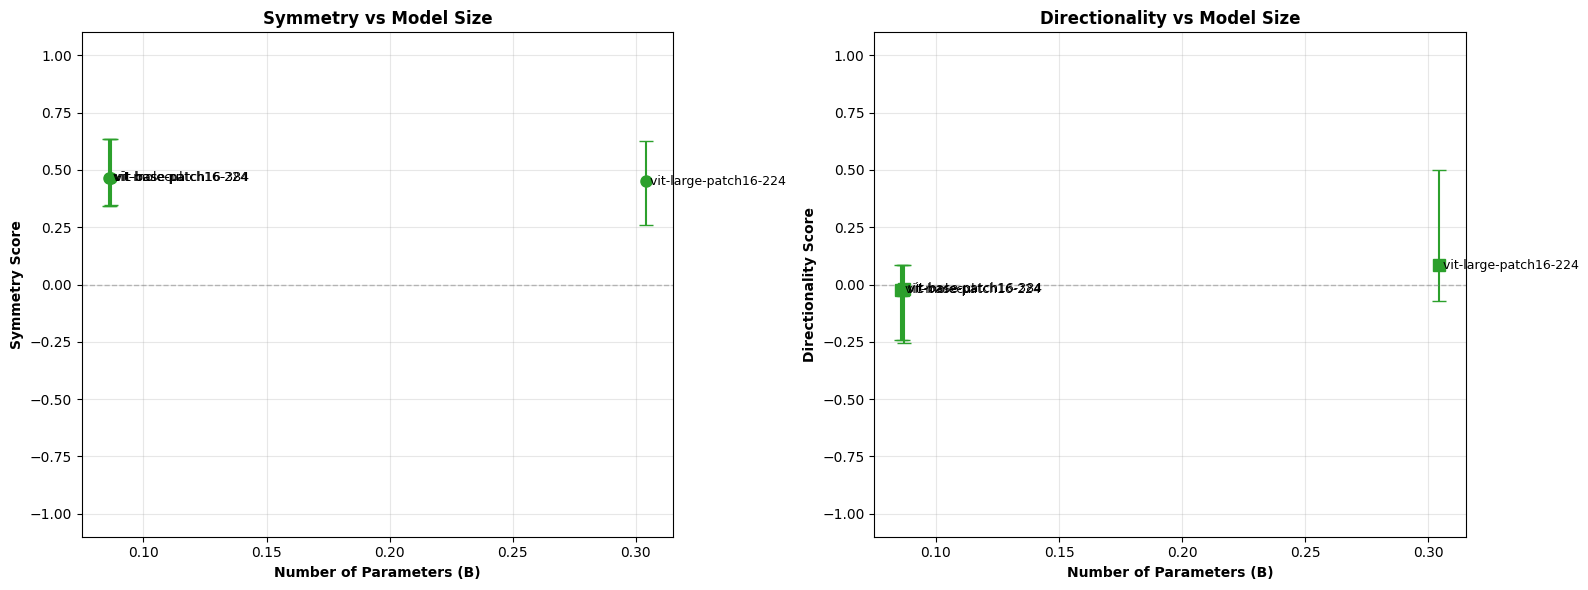

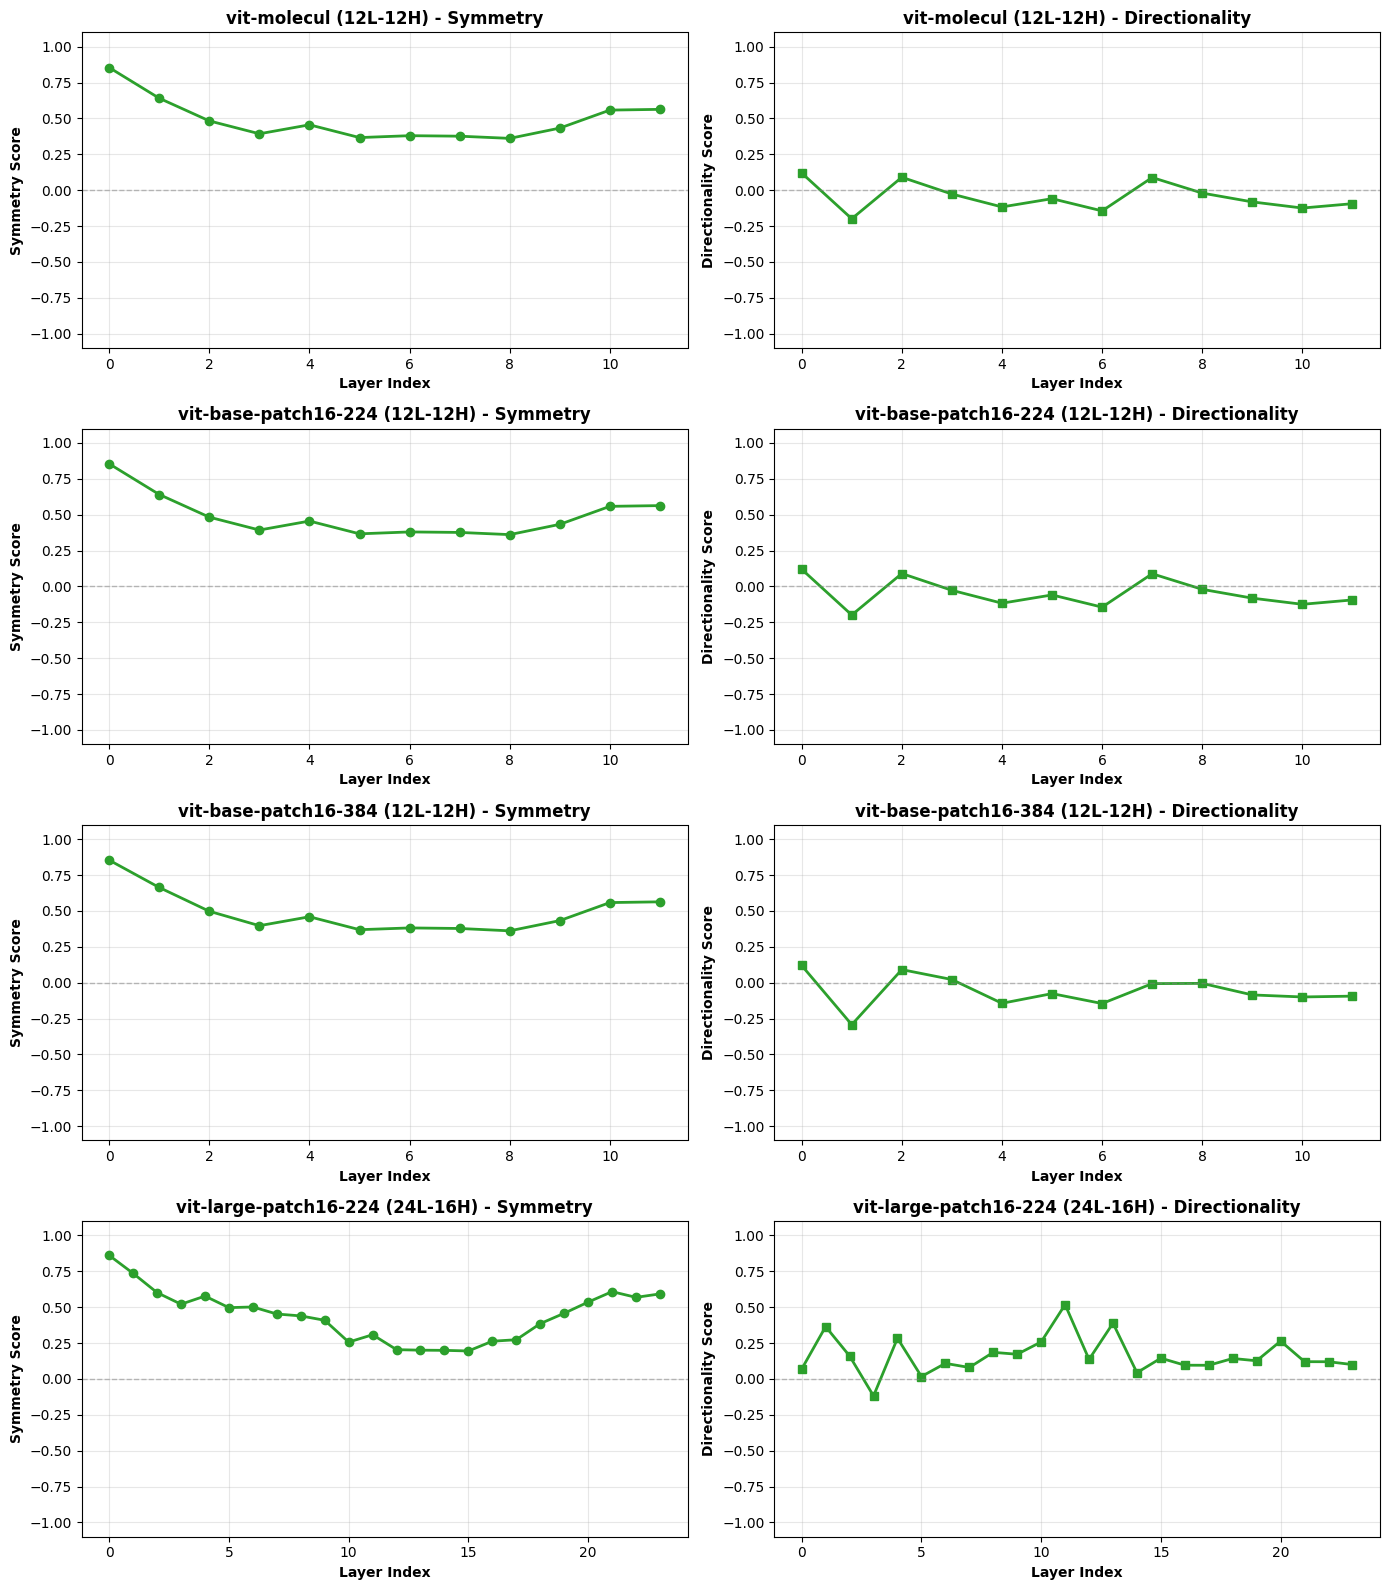

In [73]:
vit_models_config = [
    ("google/vit-base-patch16-224", "vit"),           # ViT-Base: 86M params
    ("google/vit-large-patch16-224", "vit"),          # ViT-Large: 304M params  
    ("google/vit-base-patch16-384", "vit"),           # ViT-Base 384: 86M params
    ("dyvapandhu/vit-molecul", "vit"),
    ("microsoft/swin-base-patch4-window7-224", "vit")
]


# Puis exécute ton code existant
results, types = analyze_multiple_models_with_evolution(vit_models_config)

In [29]:
def plot_average_wqk_heatmap(model, model_type: str, layer_idx: int = None):
    """
    Génère une heatmap de la matrice W_qk moyenne pour un modèle.
    
    Args:
        model: Le modèle à analyser
        model_type: Type du modèle ('bert', 'gpt2', 'vit', etc.)
        layer_idx: Index de la couche à visualiser (None = moyenne de toutes les couches)
    """
    # Extraction des informations
    wq_wk_pairs, n_heads, d_model, n_params = extract_model_info(model, model_type)
    use_gqa, n_kv_heads, kv_head_dim = has_gqa(model, wq_wk_pairs)
    
    head_dim = d_model // n_heads
    
    # Collecter toutes les matrices W_qk
    all_wqk_matrices = []
    
    if layer_idx is not None:
        # Une seule couche
        wq_wk_pairs = [wq_wk_pairs[layer_idx]]
        layer_range = [layer_idx]
    else:
        layer_range = range(len(wq_wk_pairs))
    
    for W_q, W_k in wq_wk_pairs:
        if use_gqa:
            group_size = n_heads // n_kv_heads
            for kv_idx in range(n_kv_heads):
                k_start = kv_idx * kv_head_dim
                k_end = (kv_idx + 1) * kv_head_dim
                W_k_group = W_k[k_start:k_end, :]
                
                for group_offset in range(group_size):
                    q_idx = kv_idx * group_size + group_offset
                    q_start = q_idx * head_dim
                    q_end = (q_idx + 1) * head_dim
                    W_q_head = W_q[q_start:q_end, :]
                    
                    W_qk = (W_q_head @ W_k_group.T).detach().cpu().numpy()
                    all_wqk_matrices.append(W_qk)
        else:
            for head_idx in range(n_heads):
                start = head_idx * head_dim
                end = (head_idx + 1) * head_dim
                
                W_qk = (W_q[start:end, :] @ W_k[start:end, :].T).detach().cpu().numpy()
                all_wqk_matrices.append(W_qk)
    
    # Calculer la moyenne
    avg_wqk = np.mean(all_wqk_matrices, axis=0)
    
    # Créer la heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    
    im = ax.imshow(avg_wqk, cmap='RdBu_r', aspect='auto', 
                   vmin=-np.abs(avg_wqk).max(), vmax=np.abs(avg_wqk).max())
    
    # Titre et labels
    if layer_idx is not None:
        title = f'Average W_qk Heatmap - Layer {layer_idx}'
    else:
        title = f'Average W_qk Heatmap - All {len(layer_range)} Layers'
    
    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.set_xlabel('Key Dimension', fontweight='bold')
    ax.set_ylabel('Query Dimension', fontweight='bold')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Weight Value', fontweight='bold')
    
    # Statistiques
    stats_text = f'Mean: {avg_wqk.mean():.4f}\nStd: {avg_wqk.std():.4f}\nMin: {avg_wqk.min():.4f}\nMax: {avg_wqk.max():.4f}'
    ax.text(1.15, 0.5, stats_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return avg_wqk


def plot_wqk_comparison(model, model_type: str, n_layers_to_show: int = 4):
    """
    Compare les heatmaps W_qk de plusieurs couches.
    
    Args:
        model: Le modèle à analyser
        model_type: Type du modèle
        n_layers_to_show: Nombre de couches à afficher
    """
    wq_wk_pairs, n_heads, d_model, n_params = extract_model_info(model, model_type)
    use_gqa, n_kv_heads, kv_head_dim = has_gqa(model, wq_wk_pairs)
    
    n_layers = len(wq_wk_pairs)
    head_dim = d_model // n_heads
    
    # Sélectionner les couches à afficher (début, milieu, fin)
    if n_layers <= n_layers_to_show:
        layer_indices = list(range(n_layers))
    else:
        step = n_layers // n_layers_to_show
        layer_indices = [i * step for i in range(n_layers_to_show)]
    
    n_cols = min(4, len(layer_indices))
    n_rows = (len(layer_indices) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if len(layer_indices) == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Calculer vmin/vmax global pour une échelle cohérente
    all_values = []
    for layer_idx in layer_indices:
        W_q, W_k = wq_wk_pairs[layer_idx]
        
        if use_gqa:
            # Moyenne de toutes les têtes GQA
            matrices = []
            group_size = n_heads // n_kv_heads
            for kv_idx in range(n_kv_heads):
                k_start = kv_idx * kv_head_dim
                k_end = (kv_idx + 1) * kv_head_dim
                W_k_group = W_k[k_start:k_end, :]
                
                for group_offset in range(group_size):
                    q_idx = kv_idx * group_size + group_offset
                    q_start = q_idx * head_dim
                    q_end = (q_idx + 1) * head_dim
                    W_q_head = W_q[q_start:q_end, :]
                    matrices.append((W_q_head @ W_k_group.T).detach().cpu().numpy())
            avg_matrix = np.mean(matrices, axis=0)
        else:
            # Moyenne de toutes les têtes standard
            matrices = []
            for head_idx in range(n_heads):
                start = head_idx * head_dim
                end = (head_idx + 1) * head_dim
                matrices.append((W_q[start:end, :] @ W_k[start:end, :].T).detach().cpu().numpy())
            avg_matrix = np.mean(matrices, axis=0)
        
        all_values.extend(avg_matrix.flatten())
    
    vmax = np.max(np.abs(all_values))
    vmin = -vmax
    
    # Tracer chaque couche
    for idx, layer_idx in enumerate(layer_indices):
        ax = axes[idx]
        
        W_q, W_k = wq_wk_pairs[layer_idx]
        
        if use_gqa:
            matrices = []
            group_size = n_heads // n_kv_heads
            for kv_idx in range(n_kv_heads):
                k_start = kv_idx * kv_head_dim
                k_end = (kv_idx + 1) * kv_head_dim
                W_k_group = W_k[k_start:k_end, :]
                
                for group_offset in range(group_size):
                    q_idx = kv_idx * group_size + group_offset
                    q_start = q_idx * head_dim
                    q_end = (q_idx + 1) * head_dim
                    W_q_head = W_q[q_start:q_end, :]
                    matrices.append((W_q_head @ W_k_group.T).detach().cpu().numpy())
            avg_matrix = np.mean(matrices, axis=0)
        else:
            matrices = []
            for head_idx in range(n_heads):
                start = head_idx * head_dim
                end = (head_idx + 1) * head_dim
                matrices.append((W_q[start:end, :] @ W_k[start:end, :].T).detach().cpu().numpy())
            avg_matrix = np.mean(matrices, axis=0)
        
        im = ax.imshow(avg_matrix, cmap='RdBu_r', aspect='auto', vmin=vmin, vmax=vmax)
        ax.set_title(f'Layer {layer_idx}', fontweight='bold')
        ax.set_xlabel('Key Dim')
        ax.set_ylabel('Query Dim')
    
    # Masquer les axes inutilisés
    for idx in range(len(layer_indices), len(axes)):
        axes[idx].axis('off')
    
    
    plt.suptitle(f'W_qk Heatmaps Across Layers ({model_type.upper()})', 
                 fontweight='bold', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

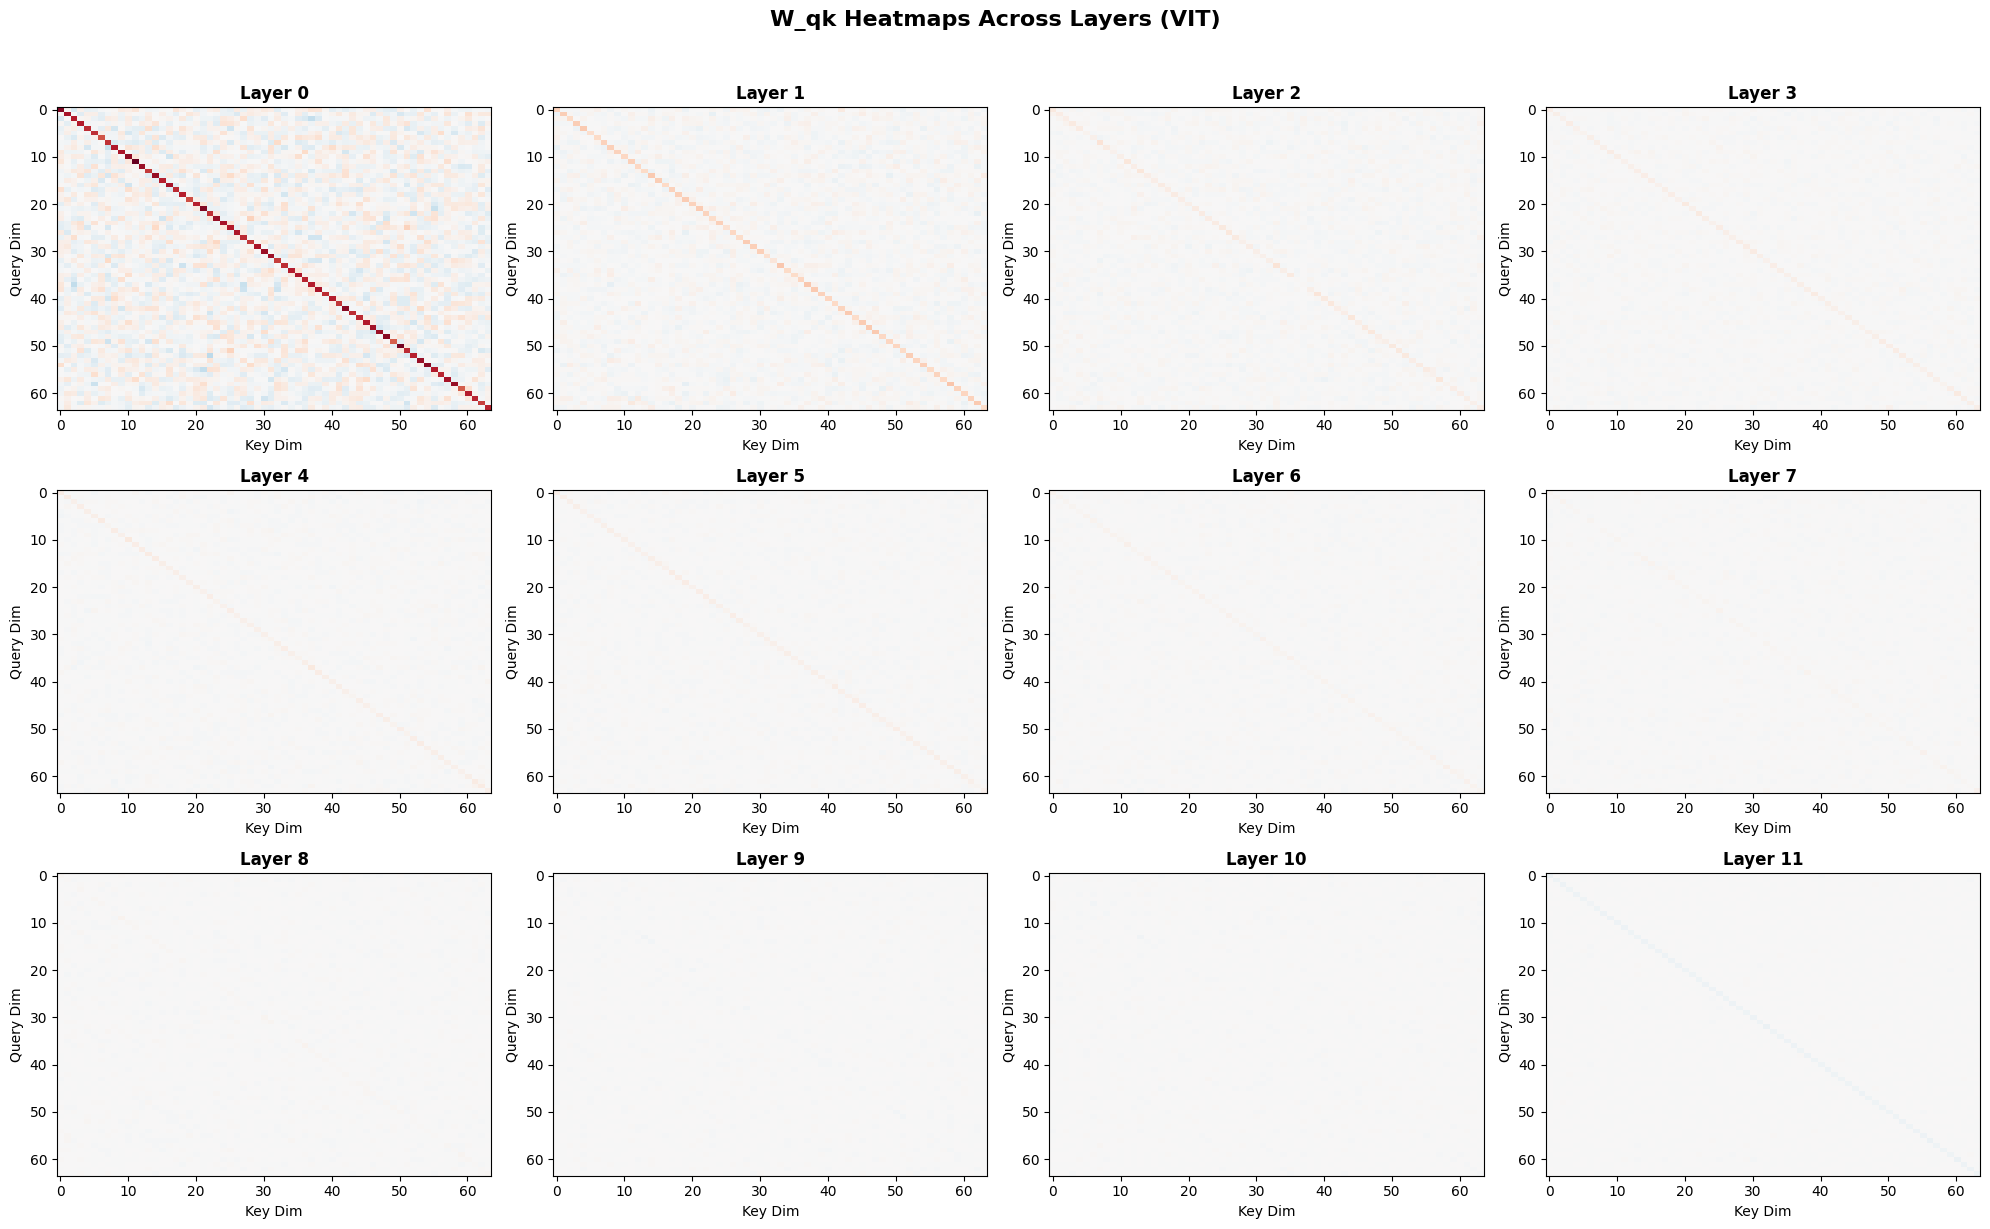

In [32]:
# Charger un modèle ViT
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Heatmap moyenne de toutes les couches
# avg_wqk = plot_average_wqk_heatmap(model, "vit")

# Heatmap d'une couche spécifique
# plot_average_wqk_heatmap(model, "vit", layer_idx=5)

# Comparer plusieurs couches
plot_wqk_comparison(model, "vit", n_layers_to_show = 12)

In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm

def visualize_symmetry(model, layer_idx=None, figsize=(20, 12)):
    """
    Visualise la symétrie des matrices W_q @ W_k^T pour un modèle ViT.
    
    Pour chaque layer/head, affiche:
    1. La matrice W_qk originale
    2. La différence de symétrie: |W_qk[i,j] - W_qk[j,i]|
    3. La matrice symétrique: (W_qk + W_qk^T) / 2
    4. La matrice antisymétrique: (W_qk - W_qk^T) / 2
    
    Args:
        model: Le modèle ViT (préentraîné ou non)
        layer_idx: Index du layer à visualiser (None = tous les layers)
        figsize: Taille de la figure
    """
    
    # Extraire les blocks du modèle
    blocks = model.blocks if hasattr(model, 'blocks') else model.encoder.layer
    
    # Déterminer quels layers à visualiser
    if layer_idx is not None:
        layers_to_viz = [layer_idx]
    else:
        layers_to_viz = range(len(blocks))
    
    for layer in layers_to_viz:
        block = blocks[layer]
        attn = block.attn if hasattr(block, 'attn') else block.attention
        
        # Récupérer W_q et W_k
        if hasattr(attn, 'qkv'):
            # Pour les implémentations avec qkv fusionné
            qkv_weight = attn.qkv.weight
            dim = qkv_weight.shape[0] // 3
            W_q = qkv_weight[:dim, :]
            W_k = qkv_weight[dim:2*dim, :]
        else:
            # Pour les implémentations séparées
            W_q = attn.query.weight if hasattr(attn, 'query') else attn.to_q.weight
            W_k = attn.key.weight if hasattr(attn, 'key') else attn.to_k.weight
        
        # Calculer W_qk = W_q @ W_k^T
        W_qk = (W_q @ W_k.T).detach().cpu().numpy()
        
        # Calculer les composantes de symétrie
        symmetry_diff = np.abs(W_qk - W_qk.T)
        symmetric_part = (W_qk + W_qk.T) / 2
        antisymmetric_part = (W_qk - W_qk.T) / 2
        
        # Calculer des statistiques
        sym_score = np.linalg.norm(symmetric_part, 'fro') / np.linalg.norm(W_qk, 'fro')
        antisym_score = np.linalg.norm(antisymmetric_part, 'fro') / np.linalg.norm(W_qk, 'fro')
        mean_diff = np.mean(symmetry_diff)
        max_diff = np.max(symmetry_diff)
        
        # Créer la figure avec 4 subplots
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(f'Layer {layer} - Analyse de Symétrie\\n'
                    f'Sym Score: {sym_score:.4f} | Antisym Score: {antisym_score:.4f} | '
                    f'Diff Moyenne: {mean_diff:.4e} | Diff Max: {max_diff:.4e}',
                    fontsize=14, fontweight='bold')
        
        # 1. Matrice originale W_qk
        vmax = np.max(np.abs(W_qk))
        norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
        im1 = axes[0, 0].imshow(W_qk, cmap='RdBu_r', norm=norm, aspect='auto')
        axes[0, 0].set_title('Matrice W_q @ W_k^T', fontsize=12)
        axes[0, 0].set_xlabel('Key Dimension')
        axes[0, 0].set_ylabel('Query Dimension')
        plt.colorbar(im1, ax=axes[0, 0])
        
        # 2. Différence de symétrie |W_qk[i,j] - W_qk[j,i]|
        im2 = axes[0, 1].imshow(symmetry_diff, cmap='hot', aspect='auto')
        axes[0, 1].set_title('Différence de Symétrie |W[i,j] - W[j,i]|', fontsize=12)
        axes[0, 1].set_xlabel('Key Dimension')
        axes[0, 1].set_ylabel('Query Dimension')
        plt.colorbar(im2, ax=axes[0, 1])
        
        # 3. Partie symétrique
        vmax_sym = np.max(np.abs(symmetric_part))
        norm_sym = TwoSlopeNorm(vmin=-vmax_sym, vcenter=0, vmax=vmax_sym)
        im3 = axes[1, 0].imshow(symmetric_part, cmap='RdBu_r', norm=norm_sym, aspect='auto')
        axes[1, 0].set_title(f'Partie Symétrique (W+W^T)/2\\nContribution: {sym_score:.2%}', fontsize=12)
        axes[1, 0].set_xlabel('Key Dimension')
        axes[1, 0].set_ylabel('Query Dimension')
        plt.colorbar(im3, ax=axes[1, 0])
        
        # 4. Partie antisymétrique
        vmax_antisym = np.max(np.abs(antisymmetric_part))
        norm_antisym = TwoSlopeNorm(vmin=-vmax_antisym, vcenter=0, vmax=vmax_antisym)
        im4 = axes[1, 1].imshow(antisymmetric_part, cmap='RdBu_r', norm=norm_antisym, aspect='auto')
        axes[1, 1].set_title(f'Partie Antisymétrique (W-W^T)/2\\nContribution: {antisym_score:.2%}', fontsize=12)
        axes[1, 1].set_xlabel('Key Dimension')
        axes[1, 1].set_ylabel('Query Dimension')
        plt.colorbar(im4, ax=axes[1, 1])
        
        plt.tight_layout()
        plt.show()
        
        # Afficher des statistiques détaillées
        print(f"\\n{'='*60}")
        print(f"Layer {layer} - Statistiques de Symétrie")
        print(f"{'='*60}")
        print(f"Score de Symétrie (Frobenius):     {sym_score:.6f}")
        print(f"Score d'Antisymétrie (Frobenius):  {antisym_score:.6f}")
        print(f"Différence moyenne |W[i,j]-W[j,i]|: {mean_diff:.6e}")
        print(f"Différence maximale:                {max_diff:.6e}")
        print(f"Norme de W_qk:                      {np.linalg.norm(W_qk, 'fro'):.6f}")
        print(f"Ratio sym/(sym+antisym):            {sym_score/(sym_score+antisym_score):.6f}")
        print(f"{'='*60}\\n")


def compare_symmetry_across_layers(model, figsize=(16, 10)):
    """
    Compare les scores de symétrie à travers tous les layers du modèle.
    
    Args:
        model: Le modèle ViT
        figsize: Taille de la figure
    """
    
    blocks = model.blocks if hasattr(model, 'blocks') else model.encoder.layer
    num_layers = len(blocks)
    
    sym_scores = []
    antisym_scores = []
    mean_diffs = []
    max_diffs = []
    
    for layer_idx in range(num_layers):
        block = blocks[layer_idx]
        attn = block.attn if hasattr(block, 'attn') else block.attention
        
        # Récupérer W_q et W_k
        if hasattr(attn, 'qkv'):
            qkv_weight = attn.qkv.weight
            dim = qkv_weight.shape[0] // 3
            W_q = qkv_weight[:dim, :]
            W_k = qkv_weight[dim:2*dim, :]
        else:
            W_q = attn.query.weight if hasattr(attn, 'query') else attn.to_q.weight
            W_k = attn.key.weight if hasattr(attn, 'key') else attn.to_k.weight
        
        W_qk = (W_q @ W_k.T).detach().cpu().numpy()
        
        symmetry_diff = np.abs(W_qk - W_qk.T)
        symmetric_part = (W_qk + W_qk.T) / 2
        antisymmetric_part = (W_qk - W_qk.T) / 2
        
        sym_score = np.linalg.norm(symmetric_part, 'fro') / np.linalg.norm(W_qk, 'fro')
        antisym_score = np.linalg.norm(antisymmetric_part, 'fro') / np.linalg.norm(W_qk, 'fro')
        
        sym_scores.append(sym_score)
        antisym_scores.append(antisym_score)
        mean_diffs.append(np.mean(symmetry_diff))
        max_diffs.append(np.max(symmetry_diff))
    
    # Créer les plots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Évolution de la Symétrie à Travers les Layers', fontsize=14, fontweight='bold')
    
    layers = np.arange(num_layers)
    
    # 1. Scores de symétrie vs antisymétrie
    axes[0, 0].plot(layers, sym_scores, 'o-', label='Symétrique', linewidth=2, markersize=8)
    axes[0, 0].plot(layers, antisym_scores, 's-', label='Antisymétrique', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Layer Index')
    axes[0, 0].set_ylabel('Score (Frobenius Norm Ratio)')
    axes[0, 0].set_title('Contributions Symétrique vs Antisymétrique')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Ratio symétrie/(symétrie+antisymétrie)
    ratio = np.array(sym_scores) / (np.array(sym_scores) + np.array(antisym_scores))
    axes[0, 1].plot(layers, ratio, 'o-', color='purple', linewidth=2, markersize=8)
    axes[0, 1].axhline(y=0.5, color='r', linestyle='--', label='Équilibre (0.5)')
    axes[0, 1].set_xlabel('Layer Index')
    axes[0, 1].set_ylabel('Ratio')
    axes[0, 1].set_title('Ratio Sym/(Sym+Antisym)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0, 1])
    
    # 3. Différence moyenne
    axes[1, 0].plot(layers, mean_diffs, 'o-', color='orange', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Layer Index')
    axes[1, 0].set_ylabel('Différence Moyenne')
    axes[1, 0].set_title('Moyenne |W[i,j] - W[j,i]|')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')
    
    # 4. Différence maximale
    axes[1, 1].plot(layers, max_diffs, 'o-', color='red', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Layer Index')
    axes[1, 1].set_ylabel('Différence Maximale')
    axes[1, 1].set_title('Max |W[i,j] - W[j,i]|')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    return sym_scores, antisym_scores, mean_diffs, max_diffs



# visualize_symmetry(vit_model, layer_idx=0)  # Pour un layer spécifique
visualize_symmetry(model)  # Pour tous les layers
# sym_scores, antisym_scores, mean_diffs, max_diffs = compare_symmetry_across_layers(vit_model)

AttributeError: 'ViTForImageClassification' object has no attribute 'encoder'


Analyse de 12 modeles...
----------------------------------------------------------------------
Chargement: bert-tiny

Model: bert-tiny
Symmetry:        0.74 +/- [0.08, 0.09]
Directionality:  -0.34 +/- [0.66, 0.81]
Parameters:      0.0B

Chargement: bert-mini

Model: bert-mini
Symmetry:        0.64 +/- [0.24, 0.20]
Directionality:  0.18 +/- [0.10, 0.18]
Parameters:      0.0B

Chargement: bert-small

Model: bert-small
Symmetry:        0.54 +/- [0.20, 0.27]
Directionality:  0.09 +/- [0.33, 0.25]
Parameters:      0.0B

Chargement: bert-medium

Model: bert-medium
Symmetry:        0.67 +/- [0.17, 0.11]
Directionality:  0.21 +/- [0.36, 0.21]
Parameters:      0.0B

Chargement: bert-base-uncased

Model: bert-base-uncased
Symmetry:        0.59 +/- [0.18, 0.15]
Directionality:  0.10 +/- [0.18, 0.16]
Parameters:      0.1B

Chargement: openai-gpt

Model: openai-gpt
Symmetry:        0.19 +/- [0.05, 0.09]
Directionality:  -0.32 +/- [0.31, 0.25]
Parameters:      0.1B

Chargement: gpt2

Model: gpt2
S

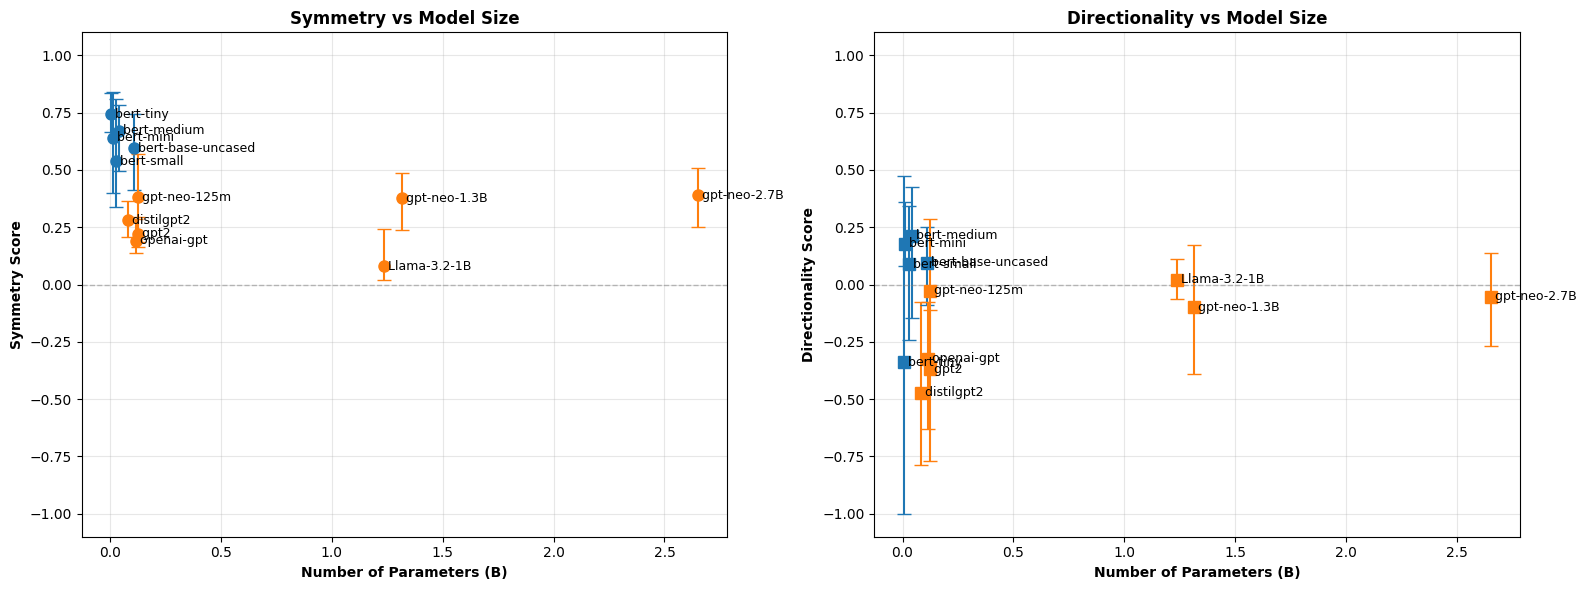

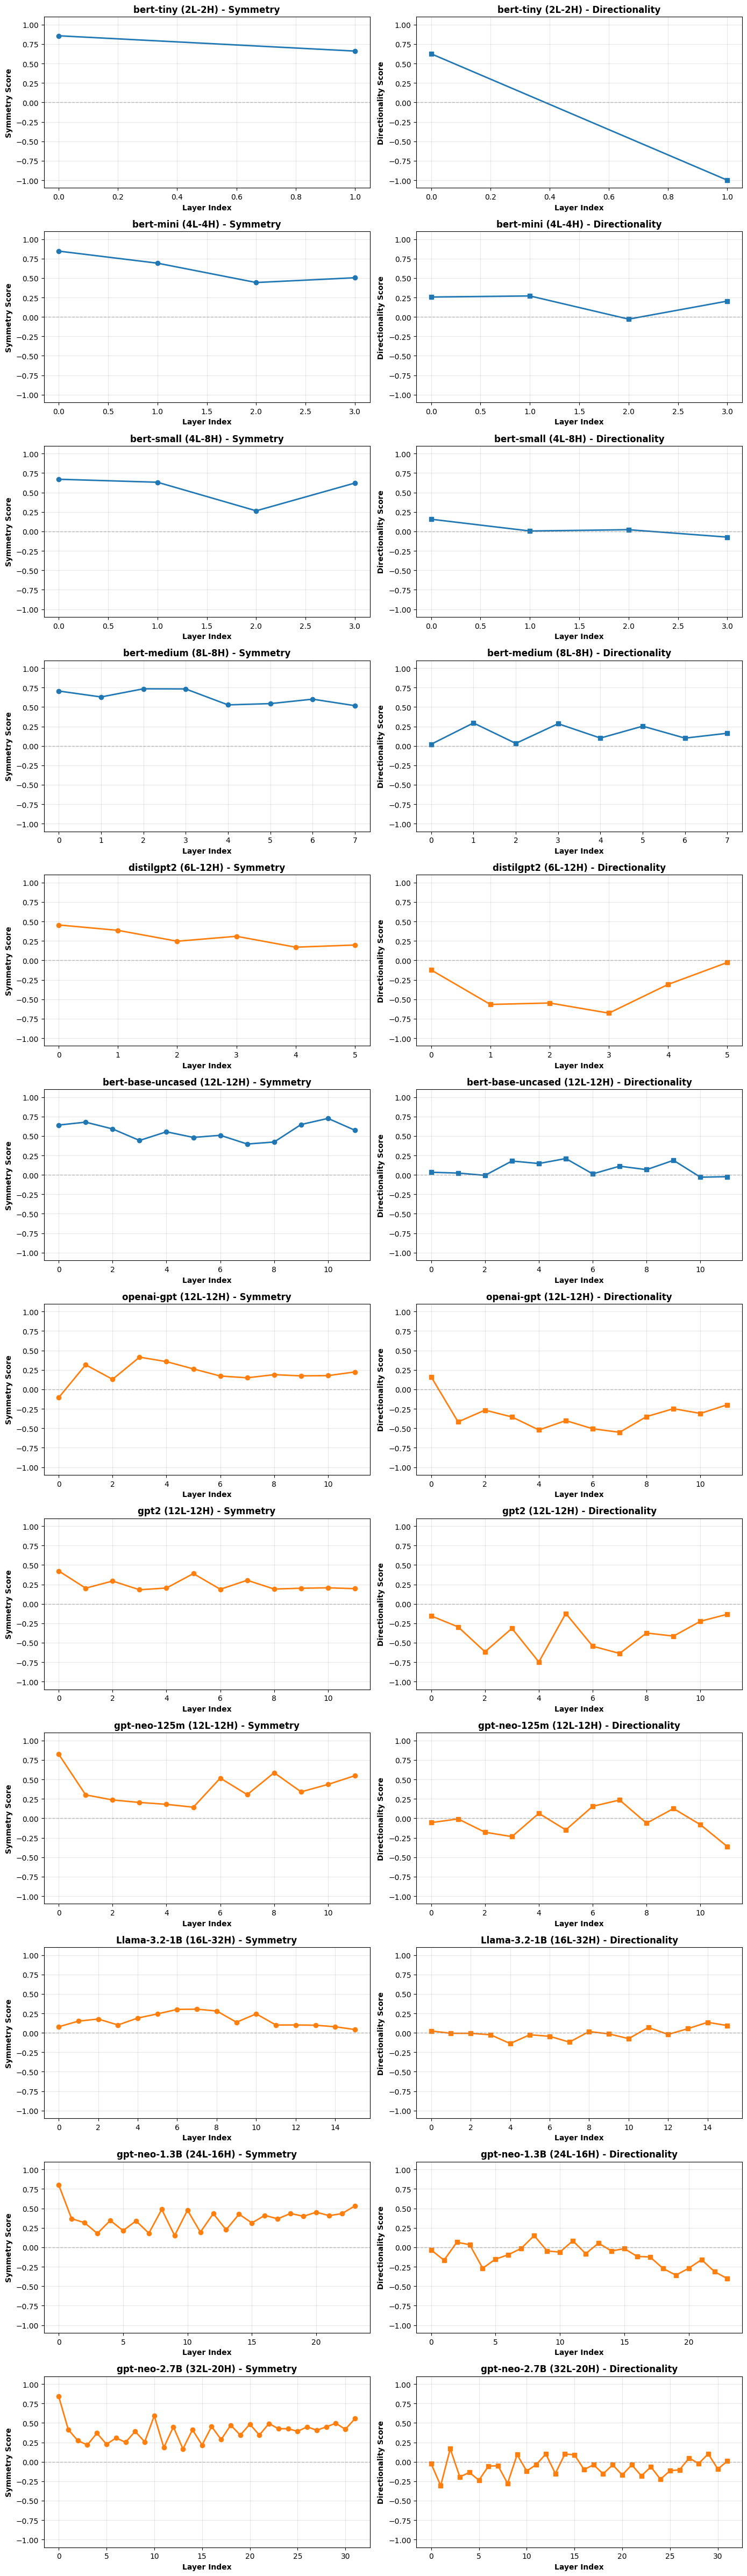

In [170]:
# Exemple d'utilisation avec évolution par couche
models_config = [
    ("prajjwal1/bert-tiny", "bert"),
    ("prajjwal1/bert-mini", "bert"),
    ("prajjwal1/bert-small", "bert"),
    ("prajjwal1/bert-medium", "bert"),
    ("google-bert/bert-base-uncased", "bert"),
    ("openai-community/openai-gpt", "gpt2"),
    ("openai-community/gpt2", "gpt2"),
    ("distilbert/distilgpt2", "gpt2"),
    ("meta-llama/Llama-3.2-1B", "llama"),

    ("EleutherAI/gpt-neo-125m", "gpt-neo"),
    ("EleutherAI/gpt-neo-1.3B", "gpt-neo"),
    ("EleutherAI/gpt-neo-2.7B", "gpt-neo"),
]
#    ("meta-llama/Llama-3.2-3B", "llama"),
results, types = analyze_multiple_models_with_evolution(models_config)